# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
import lightgbm
import gc
import os

# Plots
from matplotlib import pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Forecaster
from lightgbm import LGBMRegressor

# Multiprocessing
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from functools import partial

# Plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import display
from time import sleep
from math import ceil

# Cuda
import torch

# Pd options
pd.set_option('display.max_columns', None)

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

8


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


# Directory

In [5]:
# Set cd to parent directory
os.chdir("/Users/ignasipascual/Documents/GitHub/LightGBM-Forecaster")
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: /Users/ignasipascual/Documents/GitHub/LightGBM-Forecaster


In [6]:
# Set source
source = 'gdrive'

# Print files in directory
if source == 'local':
    # Use directory from gdrive
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Forecasting')
    print("Listing files from Google Drive 'Forecasting' directory:")
    # Drivers for cuda
    !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
    # Google colab options
    # Google
    from google.colab import output
    output.no_vertical_scroll()
else:
    print("Listing files from the current local directory:")

# List files in the specified directory
files = os.listdir()

# Print each file
for file in files:
    print(file)

Listing files from the current local directory:
.DS_Store
LICENSE
requirements.txt
utils
docs
README.md
.gitignore
submissions
.git
data
notebooks


# Assets

## Import assets

In [7]:
# Import assets
from utils.data_preparation import DataPreparation
from utils.feature_engineering import FeatureEngineering
from utils.create_baselines import CreateBaselines
from utils.forecaster import Forecaster
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [8]:
# You can use your own data, or use below example
# Source: https://www.datasource.ai/en/home/data-science-competitions-for-startups/vn1-forecasting-accuracy-challenge-phase-1/datasets

# Load data for all phases
df_prices_0 = pd.read_csv('Data/Phase 0 - Price.csv')
df_sales_0 = pd.read_csv('Data/Phase 0 - Sales.csv')
df_prices_1 = pd.read_csv('Data/Phase 1 - Price.csv')
df_sales_1 = pd.read_csv('Data/Phase 1 - Sales.csv')

# Perform a left join on 'Client', 'Warehouse', and 'Product' for prices and sales
df_prices = pd.merge(df_prices_0, df_prices_1, on=['Client', 'Warehouse', 'Product'], how='left')
df_sales = pd.merge(df_sales_0, df_sales_1, on=['Client', 'Warehouse', 'Product'], how='left')

In [9]:
# Unpivot dataset
df_prices_unpiv = unpivot_data(df_prices, id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Price')
df_sales_unpiv = unpivot_data(df_sales, id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Sales')

# Merge the two dataframes
df_input = df_sales_unpiv.merge(df_prices_unpiv, how = 'left', on = ['Client', 'Warehouse', 'Product', 'Date'])

# Round to 2 decimals
df_input['Sales'] = df_input['Sales'].round(2)
df_input['Price'] = df_input['Price'].round(2)

# Display the unpivoted dataframe
df_input.head()

,Client,Warehouse,Product,Date,Sales,Price
0,0,1,367,2020-07-06,7.0,10.90
1,0,1,639,2020-07-06,0.0,NaN
2,0,1,655,2020-07-06,21.0,21.34
3,0,1,1149,2020-07-06,7.0,11.48
4,0,1,1485,2020-07-06,0.0,NaN


## Filter scope

In [10]:
# Filter for one client
clients = range(1, 7)

# Apply filter
df_input = df_input[df_input['Client'].isin(clients)]

# Show
df_input.head()

,Client,Warehouse,Product,Date,Sales,Price
930,1,36,6101,2020-07-06,0.0,NaN
931,1,36,6795,2020-07-06,0.0,NaN
932,1,36,11992,2020-07-06,0.0,NaN
933,1,40,7628,2020-07-06,0.0,NaN
934,1,46,81,2020-07-06,0.0,NaN


## Formatting

In [11]:
# Convert all column names to lowercase
df_input.columns = df_input.columns.str.lower()

# Date format
df_input['date'] = pd.to_datetime(df_input['date'])

# Convert each specified column to string
character_cols = ['client', 'warehouse', 'product']
for col in character_cols:
    df_input[col] = df_input[col].astype(str)

# Convert signal columns to numeric, coercing errors to NaN
signal_cols = ['sales', 'price']
for col in signal_cols:
    df_input[col] = pd.to_numeric(df_input[col], errors='coerce')

# Select the specified columns
df_input = df_input[['client', 'warehouse', 'product', 'date', 'sales', 'price']]

# Sort by 'id_column' and 'date' in ascending order
df_input = df_input.sort_values(by=['client', 'warehouse', 'product', 'date'])

# Show
df_input.head()

,client,warehouse,product,date,sales,price
1573,1,151,10060,2020-07-06,0.0,NaN
16626,1,151,10060,2020-07-13,0.0,NaN
31679,1,151,10060,2020-07-20,0.0,NaN
46732,1,151,10060,2020-07-27,0.0,NaN
61785,1,151,10060,2020-08-03,0.0,NaN


## Statistics

In [12]:
# Print the number of rows and columns
print(f"Number of columns in df_input: {df_input.shape[1]}")
print(f"Number of rows in df_input: {df_input.shape[0]}")

# Print the number of distinct values for each specified column
print(f"Number of distinct clients: {df_input['client'].nunique()}")
print(f"Number of distinct warehouses: {df_input['warehouse'].nunique()}")
print(f"Number of distinct products: {df_input['product'].nunique()}")

Number of columns in df_input: 6
Number of rows in df_input: 537288
Number of distinct clients: 6
Number of distinct warehouses: 37
Number of distinct products: 2378


In [13]:
# Calculate the percentage of NA values in the entire DataFrame
total_rows = len(df_input)
total_na = df_input.isna().sum().sum()
percent_na_total = (total_na / (total_rows * df_input.shape[1])) * 100
print(f"Percentage of NA values: {percent_na_total:.2f}%")

Percentage of NA values: 11.96%


# Data Preparation

In [14]:
# Init class
data_preparation = DataPreparation()

In [15]:
# Run data preparation
df_data_prepared = data_preparation.run_data_preparation(
    df=df_input,
    group_cols=['client', 'warehouse', 'product'],
    date_col='date',
    target='sales',
    horizon=13,
    freq='W',
    complete_dataframe=False,
    smoothing=True,
    ma_window_size=13,
    n_cutoffs=5
)

# Show
df_data_prepared.head()

Starting data preparation...
Identified signal columns: ['sales', 'price']
Applied smoothing with a moving average window size of 13.
Identified cutoff dates for backtesting: [Timestamp('2024-01-01 00:00:00'), Timestamp('2023-12-04 00:00:00'), Timestamp('2023-11-06 00:00:00'), Timestamp('2023-10-02 00:00:00'), Timestamp('2023-09-04 00:00:00')]
Created backtesting DataFrame.
Added forecasting horizon for the last cutoff.
Data preparation completed. Returning prepared DataFrame.


,client,warehouse,product,date,sales,price,filled_sales,filled_price,cutoff,sample
1611864,1,151,10060,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train
1611865,1,151,10060,2020-07-13,0.0,NaN,0.0,NaN,2023-09-04,train
1611866,1,151,10060,2020-07-20,0.0,NaN,0.0,NaN,2023-09-04,train
1611867,1,151,10060,2020-07-27,0.0,NaN,0.0,NaN,2023-09-04,train
1611868,1,151,10060,2020-08-03,0.0,NaN,0.0,NaN,2023-09-04,train


# Feature Engineering

In [16]:
# Init class
feature_engineering = FeatureEngineering()

In [17]:
# Run feature engineering
df_with_features = feature_engineering.run_feature_engineering(
    df=df_data_prepared,
    group_cols=['client', 'warehouse', 'product', 'cutoff'],
    date_col='date',
    target='filled_sales',
    horizon=13,
    freq='W',
    window_sizes=(4, 13),
    lags=(4, 13),
    n_clusters=15
)

Starting feature engineering...
Identified signal columns: ['sales', 'price', 'filled_sales', 'filled_price']
Identified categorical columns for encoding: ['client', 'warehouse', 'product']
Encoded categorical features.
Added date features.
Added periods feature.
Identified signal columns: ['sales', 'price', 'filled_sales', 'filled_price']
Added moving average features.
Added moving statistics.
Added lag features.
Added coefficient of variance feature for the target variable.
Added quantile clusters.
Added history clusters.
Added train weights based on the specified weighting type.
Added forecast lag numbers.
Feature engineering completed. Returning prepared DataFrame.


# Create Baselines

In [18]:
# Parameters for baseline creation
group_columns = ['client', 'warehouse', 'product', 'cutoff']
date_column = 'date'

In [19]:
# Prepare class
create_baselines = CreateBaselines()

In [20]:
# Parameters
signal_columns = ['filled_sales_ma_13', 'filled_price_ma_13']
window_size = 13

# Call the function
df_with_ma_baseline = create_baselines.create_ma_baseline(df_with_features, group_columns, date_column, signal_columns, window_size)

# Show
df_with_ma_baseline.head()

,client,warehouse,product,date,sales,price,filled_sales,filled_price,cutoff,sample,feature_client,feature_warehouse,feature_product,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_ma_4,sales_ma_13,price_ma_4,price_ma_13,filled_sales_ma_4,filled_sales_ma_13,filled_price_ma_4,filled_price_ma_13,sales_min_4,sales_max_4,sales_min_13,sales_max_13,price_min_4,price_max_4,price_min_13,price_max_13,filled_sales_min_4,filled_sales_max_4,filled_sales_min_13,filled_sales_max_13,filled_price_min_4,filled_price_max_4,filled_price_min_13,filled_price_max_13,feature_sales_lag_4,feature_sales_lag_13,feature_price_lag_4,feature_price_lag_13,feature_filled_sales_lag_4,feature_filled_sales_lag_13,feature_filled_price_lag_4,feature_filled_price_lag_13,feature_filled_sales_cov,feature_filled_sales_cluster,feature_filled_sales_history_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_ma_13,feature_baseline_filled_price_ma_13,baseline_filled_sales_ma_13,baseline_filled_price_ma_13
0,1,151,10060,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train,0,7,14,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606092,3,5,0.0,<NA>,0.0,NaN,NaN,NaN
1,1,151,10060,2020-07-13,0.0,NaN,0.0,NaN,2023-09-04,train,0,7,14,2020,3,7,29,11,24,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606092,3,5,0.0,<NA>,0.0,NaN,NaN,NaN
2,1,151,10060,2020-07-20,0.0,NaN,0.0,NaN,2023-09-04,train,0,7,14,2020,3,7,30,10,23,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606092,3,5,0.0,<NA>,0.0,NaN,NaN,NaN
3,1,151,10060,2020-07-27,0.0,NaN,0.0,NaN,2023-09-04,train,0,7,14,2020,3,7,31,9,22,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606092,3,5,0.0,<NA>,0.0,NaN,NaN,NaN
4,1,151,10060,2020-08-03,0.0,NaN,0.0,NaN,2023-09-04,train,0,7,14,2020,3,8,32,8,21,1,4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.606092,3,5,0.0,<NA>,0.0,NaN,NaN,NaN


In [21]:
# Parameters
group_columns = ['feature_filled_sales_cluster', 'cutoff']
signal_columns = ['filled_price']
feature_columns = ['feature_client', 'feature_warehouse', 'feature_product', 'feature_periods', 'feature_year', 'feature_quarter', 'feature_month', 'feature_week']

# Call the function
df_backtesting = create_baselines.create_lgbm_baseline(df_with_ma_baseline, group_columns, date_column, signal_columns, feature_columns)

# Show
df_backtesting.head()

,client,warehouse,product,date,sales,price,filled_sales,filled_price,cutoff,sample,feature_client,feature_warehouse,feature_product,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_ma_4,sales_ma_13,price_ma_4,price_ma_13,filled_sales_ma_4,filled_sales_ma_13,filled_price_ma_4,filled_price_ma_13,sales_min_4,sales_max_4,sales_min_13,sales_max_13,price_min_4,price_max_4,price_min_13,price_max_13,filled_sales_min_4,filled_sales_max_4,filled_sales_min_13,filled_sales_max_13,filled_price_min_4,filled_price_max_4,filled_price_min_13,filled_price_max_13,feature_sales_lag_4,feature_sales_lag_13,feature_price_lag_4,feature_price_lag_13,feature_filled_sales_lag_4,feature_filled_sales_lag_13,feature_filled_price_lag_4,feature_filled_price_lag_13,feature_filled_sales_cov,feature_filled_sales_cluster,feature_filled_sales_history_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_ma_13,feature_baseline_filled_price_ma_13,baseline_filled_sales_ma_13,baseline_filled_price_ma_13,baseline_filled_price_lgbm,feature_baseline_filled_price_lgbm
0,1,151,1241,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train,0,7,426,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,<NA>,0.0,NaN,NaN,NaN,NaN,NaN
1,1,182,10534,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train,0,8,105,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN
2,1,182,11810,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train,0,8,311,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN
3,1,182,11992,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train,0,8,345,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN
4,1,182,12590,2020-07-06,0.0,NaN,0.0,NaN,2023-09-04,train,0,8,467,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN


# Forecasting model

## Features

In [22]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_backtesting.columns if "feature" in col]

# Create default trainining group
df_backtesting['training_group'] = 1

# Show
features

['feature_client',
 'feature_warehouse',
 'feature_product',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_weeks_until_next_end_of_quarter',
 'feature_weeks_until_end_of_year',
 'feature_months_until_next_end_of_quarter',
 'feature_months_until_end_of_year',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_sales_lag_4',
 'feature_sales_lag_13',
 'feature_price_lag_4',
 'feature_price_lag_13',
 'feature_filled_sales_lag_4',
 'feature_filled_sales_lag_13',
 'feature_filled_price_lag_4',
 'feature_filled_price_lag_13',
 'feature_filled_sales_cov',
 'feature_filled_sales_cluster',
 'feature_filled_sales_history_cluster',
 'feature_baseline_filled_sales_ma_13',
 'feature_baseline_filled_price_ma_13',
 'feature_baseline_filled_price_lgbm']

In [23]:
# Number of features
print("Number of features:", len(features))

Number of features: 28


## Hyperparameters

In [24]:
# Define the default LightGBM hyperparameters
default_lgb_hyperparams = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'n_estimators': 2500,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'seed': 42
}

# Define the expanded LightGBM parameters for grid search
hyperparameter_grid = {
    # Core Parameters
    'objective': ['regression'],
    'boosting_type': ['gbdt', 'dart'],
    'metric': ['rmse', 'mae'],
    'n_estimators': [1000, 2000, 3000],
    'learning_rate': [0.01, 0.05, 0.10],
    'num_leaves': [16, 31, 48],
    'max_depth': [4, 8, 12],
    # Control Overfitting Parameters
    'min_data_in_leaf': [20, 50, 80],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'bagging_freq': [1, 3, 5, 9],
    # Regularization Parameters
    'lambda_l1': [0.0, 0.4, 1.0],
    'lambda_l2': [0.0, 0.4, 1.0],
    'min_gain_to_split': [0.0, 0.1, 0.2],
    'min_child_weight': [1e-3, 1e-2, 1e-1]
}

# Calculate the number of combinations directly
num_combinations = (
    len(hyperparameter_grid['objective']) *
    len(hyperparameter_grid['boosting_type']) *
    len(hyperparameter_grid['metric']) *
    len(hyperparameter_grid['n_estimators']) *
    len(hyperparameter_grid['learning_rate']) *
    len(hyperparameter_grid['num_leaves']) *
    len(hyperparameter_grid['max_depth']) *
    len(hyperparameter_grid['min_data_in_leaf']) *
    len(hyperparameter_grid['feature_fraction']) *
    len(hyperparameter_grid['bagging_fraction']) *
    len(hyperparameter_grid['bagging_freq']) *
    len(hyperparameter_grid['lambda_l1']) *
    len(hyperparameter_grid['lambda_l2']) *
    len(hyperparameter_grid['min_gain_to_split']) *
    len(hyperparameter_grid['min_child_weight'])
)

# Print the result with formatting for better readability
print(f"Number of potential combinations for Grid Search: {num_combinations:,}")

Number of potential combinations for Grid Search: 2,834,352


## Configuration

In [25]:
# Parameters
group_cols = ['client', 'warehouse', 'product']
training_group = 'feature_filled_sales_cluster'
target_col = 'filled_sales'
tune_hyperparameters = False
search_method = 'halving'
param_distributions = hyperparameter_grid
scoring_metric = 'neg_root_mean_squared_error'
best_features = True
n_best_features = 15
use_weights = True

# Outliers
remove_outliers = True
outlier_column = 'filled_sales'
lower_quantile = 0.01
upper_quantile = 0.99
ts_decomposition = False

# Guardrail
baseline_col = 'baseline_filled_sales_ma_13'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

## Run Predictor

In [26]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_backtesting)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_lgb_hyperparams,
    training_group,
    target_col,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    ts_decomposition,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)

Number of cutoffs detected:  5
CUDA is not available, using CPU with 8 available cores
Running predictions sequentially
----------------------------------------------------------

Processing cutoff 1/5 (20.00%) - Cutoff: 2023-09-04 00:00:00
----------------------------------------------------------
Selecting 15 best numeric features for cutoff 2023-09-04 00:00:00 using mutual information
Total number of features before selection: 28
Total number of features after selection: 28
Training and predicting for cutoff: 2023-09-04 00:00:00, training group: 1 (6.67% of groups in cutoff)
Calculating guardrail for cutoff: 2023-09-04 00:00:00, training group: 1
Training and predicting for cutoff: 2023-09-04 00:00:00, training group: 2 (13.33% of groups in cutoff)
Calculating guardrail for cutoff: 2023-09-04 00:00:00, training group: 2
Training and predicting for cutoff: 2023-09-04 00:00:00, training group: 3 (20.00% of groups in cutoff)
Calculating guardrail for cutoff: 2023-09-04 00:00:00, traini

## Optimization

In [27]:
# If hyperparameter tuning retrieve best combination
if tune_hyperparameters:

  # Retrieve and print the best hyperparameters for each cutoff
  best_hyperparams = forecaster.get_best_hyperparams()
  print("Best Hyperparameters for each cutoff:")

  # Show
  for cutoff, params in best_hyperparams.items():
      print(f"Cutoff {cutoff}: {params}")

## Guardrail

In [28]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['client', 'warehouse', 'product', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups =  df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

Percentage of groups where guardrail is True: 0.00%


# Evaluate results

## Feature importance

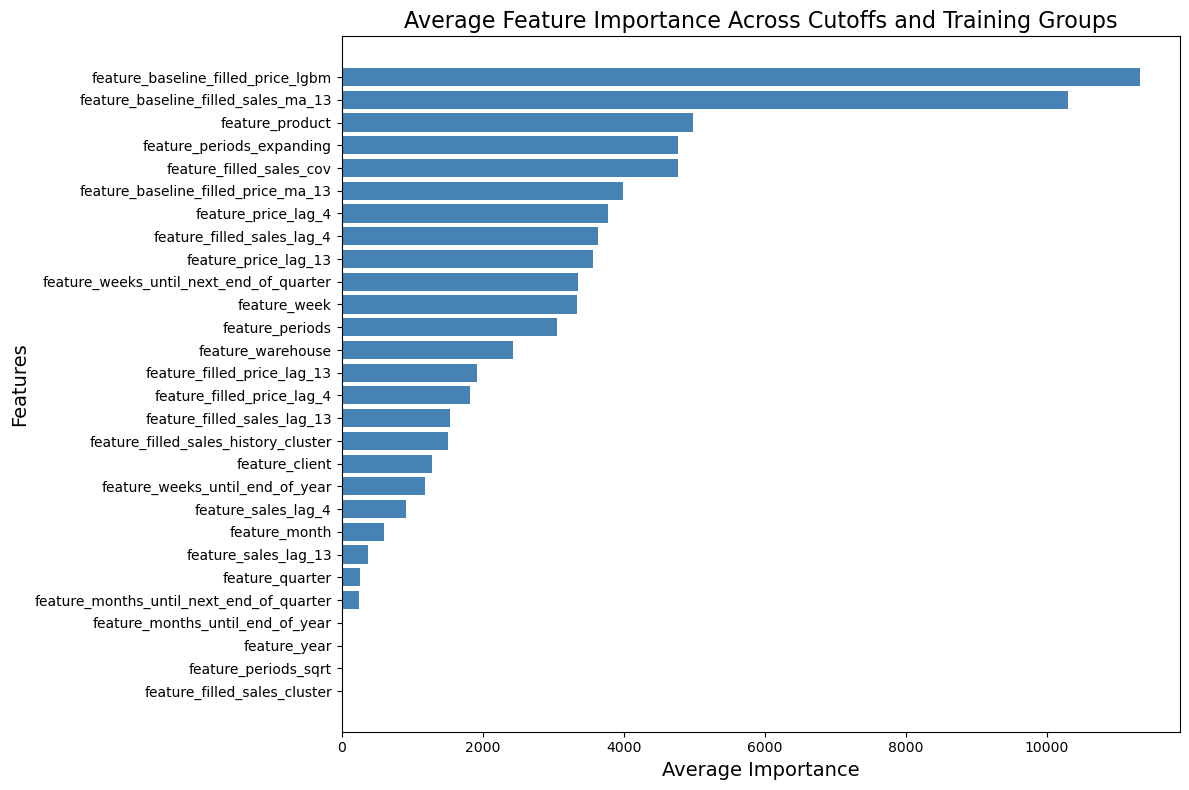

In [29]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance()

## Run evaluator

In [30]:
# Params
actuals_col = 'sales'
baseline_col = 'baseline_filled_sales_ma_13'
preds_col = ['prediction']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_preds, actuals_col, baseline_col, preds_col)

# Create and print metric table
metric_table = evaluator.create_metric_table()

# Show
metric_table

,RMSE,MAE,MAPE,WMAPE,Custom Metric
baseline_filled_sales_ma_13,72.31,25.69,137.92,60.94,88.42
prediction,60.09,21.18,125.47,50.23,66.82


## Lag metrics

In [31]:
# Params
metric_name = 'WMAPE'
group_col = 'fcst_lag'

# Call the function
lag_metrics = evaluator.calculate_grouped_metric(metric_name, group_col)

# Show
lag_metrics

fcst_lag,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Baseline,50.261407,54.429642,60.210550,57.636342,56.524254,60.384617,61.182688,65.935961,58.906936,64.014404,66.165794,71.148501,66.648688,65.555626,71.232748,71.969200,71.282269,62.312988
prediction,38.587529,41.477314,50.915659,49.837275,47.873030,47.876522,50.497279,56.126468,48.376577,51.933453,53.730600,60.487275,55.208149,56.366666,58.363149,59.633941,61.778178,52.887021


# Plot predictions


In [32]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Show
df_filtered.head()

,client,warehouse,product,date,sales,price,filled_sales,filled_price,cutoff,sample,feature_client,feature_warehouse,feature_product,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_ma_4,sales_ma_13,price_ma_4,price_ma_13,filled_sales_ma_4,filled_sales_ma_13,filled_price_ma_4,filled_price_ma_13,sales_min_4,sales_max_4,sales_min_13,sales_max_13,price_min_4,price_max_4,price_min_13,price_max_13,filled_sales_min_4,filled_sales_max_4,filled_sales_min_13,filled_sales_max_13,filled_price_min_4,filled_price_max_4,filled_price_min_13,filled_price_max_13,feature_sales_lag_4,feature_sales_lag_13,feature_price_lag_4,feature_price_lag_13,feature_filled_sales_lag_4,feature_filled_sales_lag_13,feature_filled_price_lag_4,feature_filled_price_lag_13,feature_filled_sales_cov,feature_filled_sales_cluster,feature_filled_sales_history_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_ma_13,feature_baseline_filled_price_ma_13,baseline_filled_sales_ma_13,baseline_filled_price_ma_13,baseline_filled_price_lgbm,feature_baseline_filled_price_lgbm,training_group,guardrail,prediction
2149152,1,151,1241,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,7,426,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
2149153,1,182,10534,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,8,105,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
2149154,1,182,12590,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,8,467,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
2149155,1,182,13223,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,8,580,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN
2149156,1,182,3306,2020-07-06,0.0,NaN,0.0,NaN,2024-01-01,train,0,8,1133,2020,3,7,28,12,25,2,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,0.0,<NA>,0.0,NaN,NaN,NaN,NaN,NaN,1,False,NaN


In [33]:
# Params
baseline_col = 'baseline_filled_sales_ma_13'
top_n_plots = 6

## Plot by client

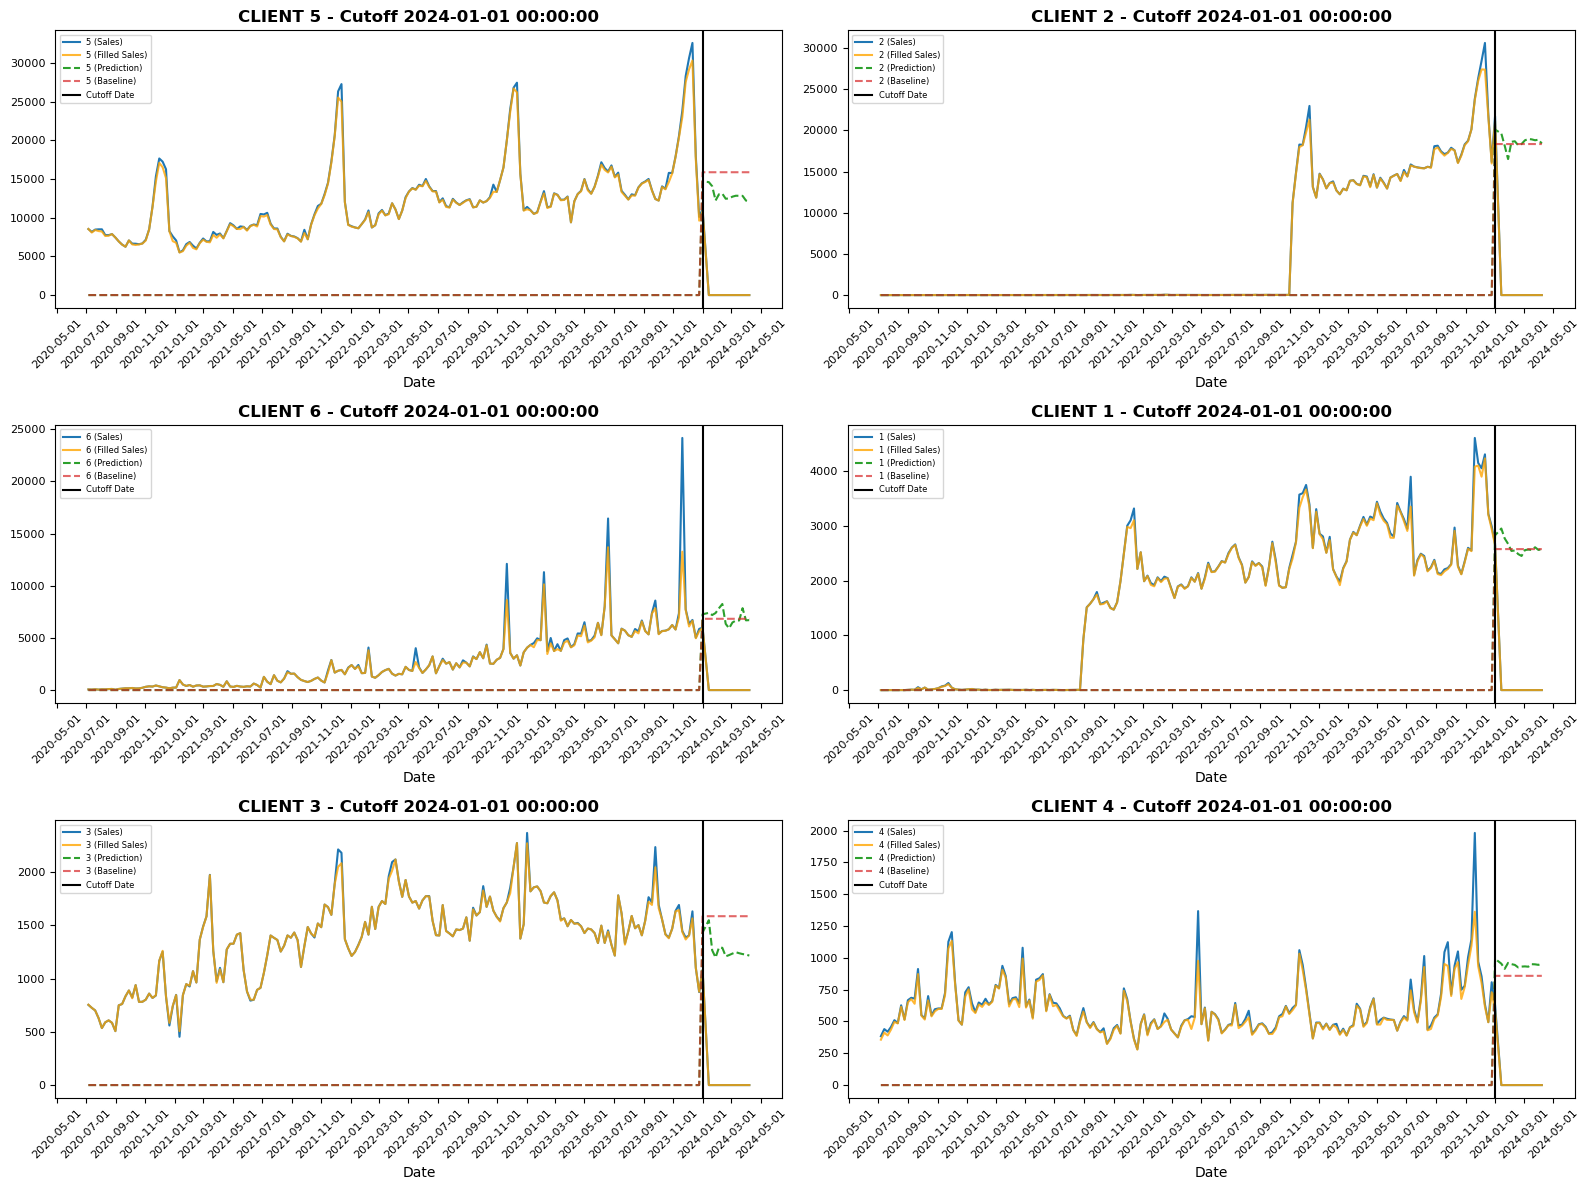

In [34]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='client',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Clients Sales vs Baseline vs Prediction'
)

## Plot by warehouse

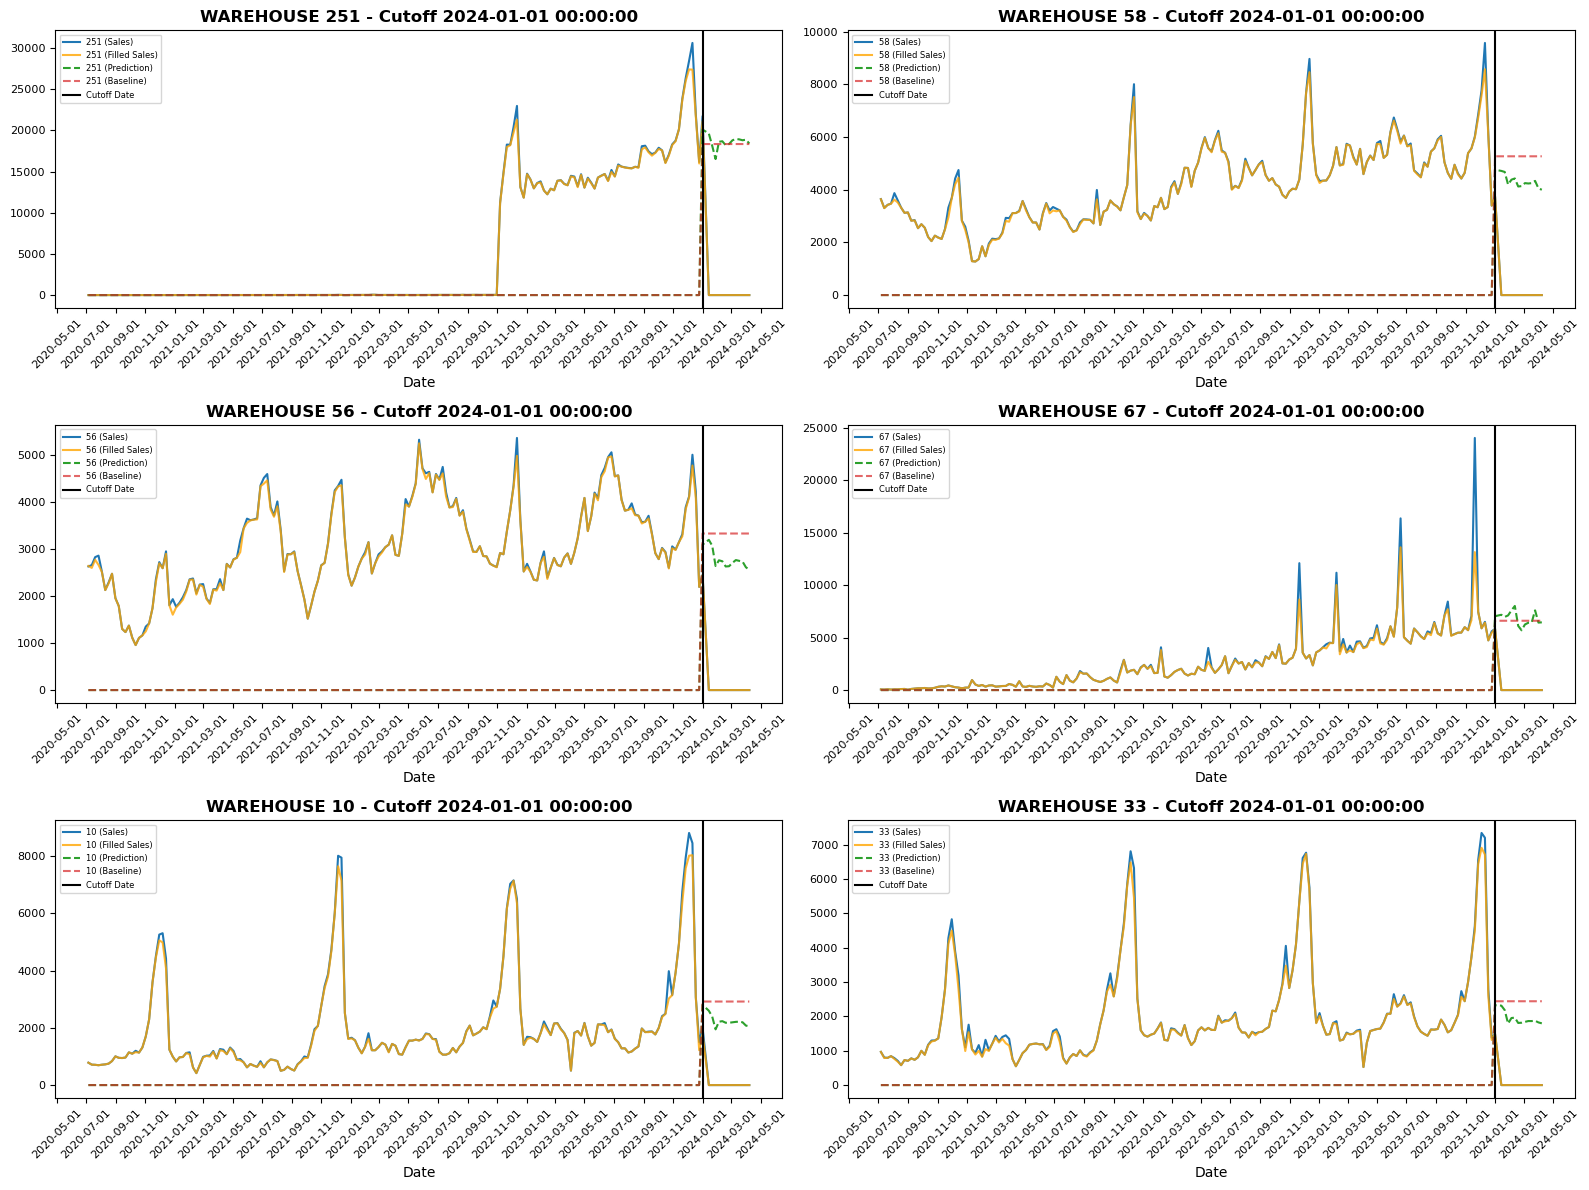

In [35]:
# Plot by warehouse
process_and_plot(
    df_filtered,
    group_col='warehouse',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Warehouses Sales vs Baseline vs Prediction'
)

## Plot by Product

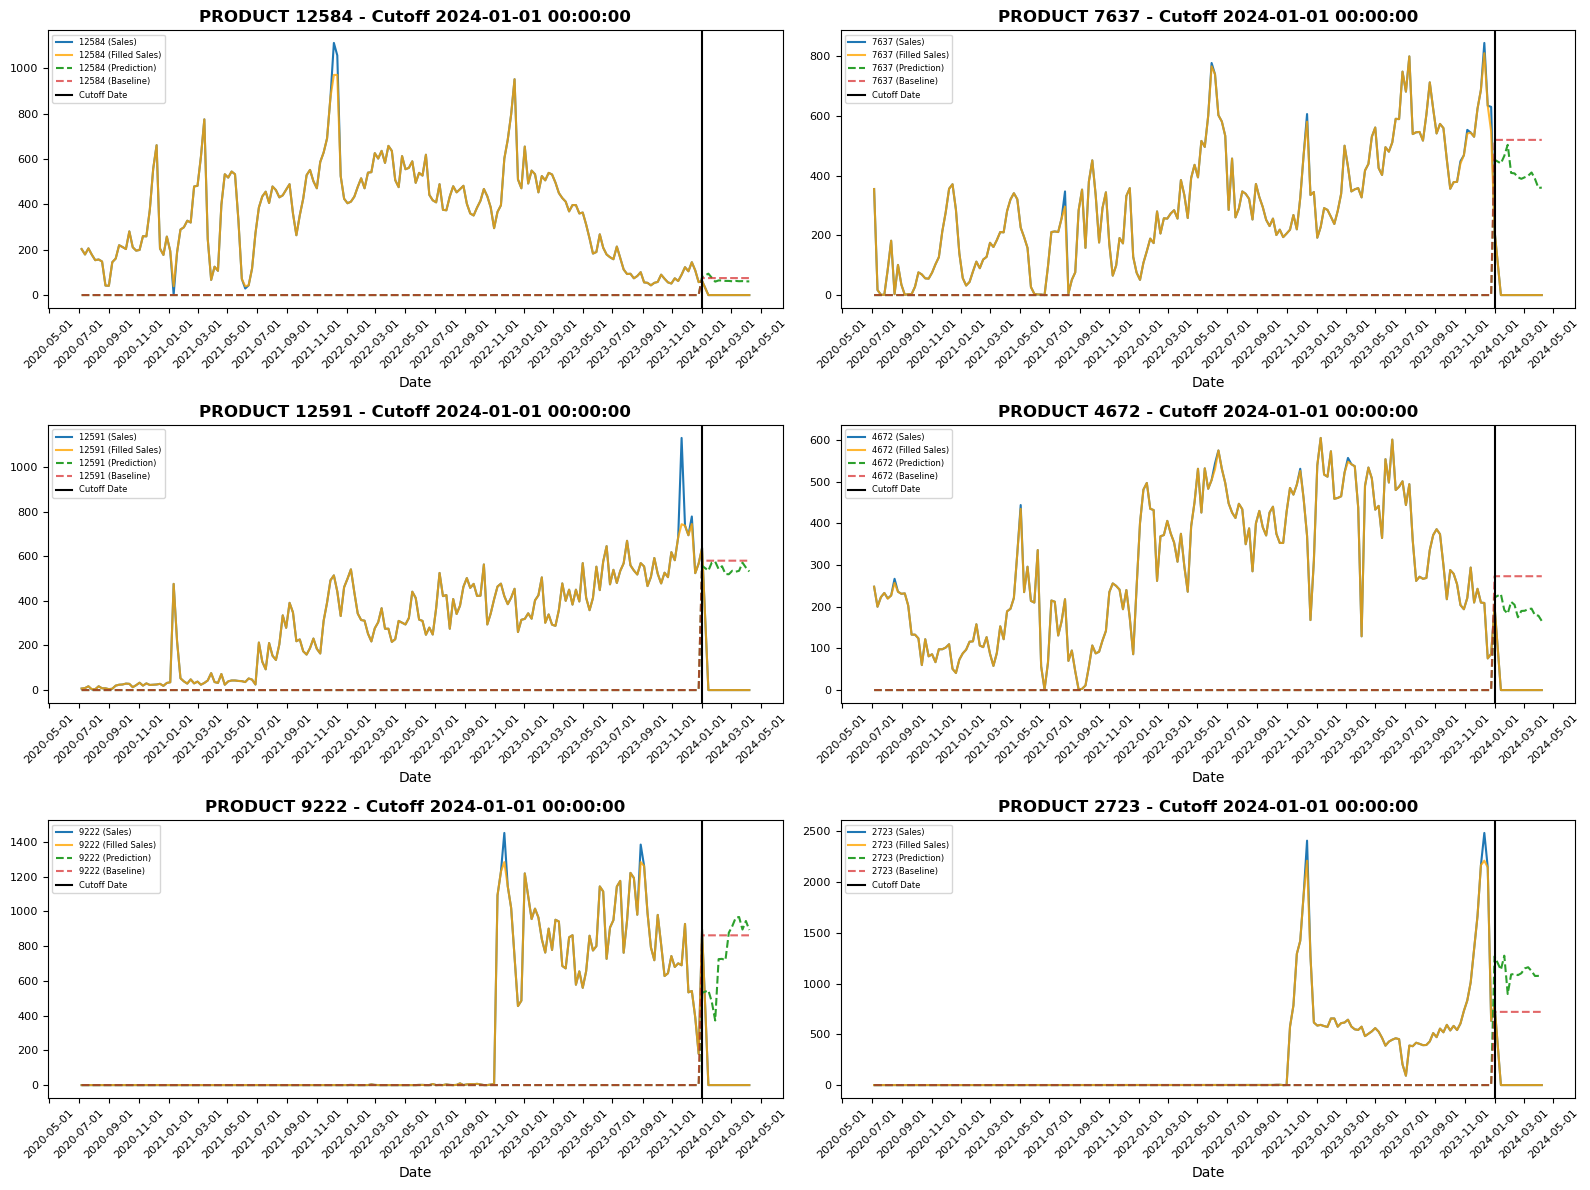

In [36]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Products Sales vs Baseline vs Prediction'
)

# Save output

In [37]:
# Create the filename with the phase appended
file_name = f'Data/df_lightgbm_runner_preds.csv'

# Write the dataframe to the CSV file
df_with_preds.to_csv(file_name, index=False)

# Clean

In [38]:
# Garbage collection
gc.collect()

0